In [505]:
# ! pip install imutils
# ! pip install scikit-image
# ! pip install tensorflow
import argparse
import imutils
import cv2

from os import listdir
import cv2
import sys
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage import exposure
from tensorflow.keras.models import load_model
import pickle

input_path = '../data/Set1Part0'
output_path = "pikles"
img_size=(30,30,3)


#Read in image files
# images_files = [f for f in listdir(input_path + 'dataset')]
images_files = [f for f in listdir(input_path)]

images_files = images_files[:20]

images = {}

for image_file in images_files:
    images[image_file] = (cv2.imread(input_path + "/" + image_file))
    
sign_or_not = pickle.load(open("sign_or_not_classifier.pkl", 'rb'))


def classify_signs(classifier_model, img_list, confidence):
    # returns 1 if sign, 0 if not
    
    flat_data_arr_ = []
    
    for i in img_list:
        flat_data_arr_.append(cv2.resize(i, [32, 32]).flatten())
    
    flat_data_=np.array(flat_data_arr_)

    df_=pd.DataFrame(flat_data_) #dataframe
    df_['Target']="useless"
    x_=df_.iloc[:,:-1] #input data 
    
    pred = classifier_model.predict_proba(x_)
    
    preds = []
    for i in pred:
        if i[0] >= confidence:
            preds.append(0)
        else:
            preds.append(1)
    return preds

def blue_mask(img):
    
    # img = constrastLimit(img)
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_blue= np.array([78,158,124])
    upper_blue = np.array([138,255,255])

    mask = cv2.inRange(hsv,lower_blue,upper_blue)
    
    cnt, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(mask, cnt, -1, (0,255,0), 3)
    
    return mask
    

def red_mask(img):
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # mask2 = cv2.inRange(hsv, (80, 70, 130), (255, 255, 255))
    # lower mask (0-10)
    lower_red = np.array([0,50,50])
    upper_red = np.array([12,255,255])
    mask0 = cv2.inRange(hsv, lower_red, upper_red)

    # upper mask (170-180)
    lower_red = np.array([170,50,50])
    upper_red = np.array([182,255,255])
    mask1 = cv2.inRange(hsv, lower_red, upper_red)

    # join my masks
    mask = mask0+mask1
    
    cnt, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(mask, cnt, -1, (0,255,0), 3)
    
    
    return mask

def yellow_mask(img):
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_yellow= np.array([20,100,100])
    upper_yellow = np.array([30,255,255])

    mask = cv2.inRange(hsv,lower_yellow,upper_yellow)
    
    cnt, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(mask, cnt, -1, (0,255,0), 3)
    
    return mask

def coordsIntersect(candidate_coords, list_coords):
    
    x,y,w,h = candidate_coords
    # middle point
    can_x, can_y = ((2*x+w)/2 , (2*y+h)/2)
    
    for coord_comb in list_coords:
        x_, y_, w_, h_ = coord_comb
        
        # if middle point of candidate is inside any existing rect then return False
        if (can_x < (x_ + w_)) & (can_x > x_):
            if (can_y < (y_ + h_)) & (can_y > y_):
                return False
        
    return True


def return_interesting_area_coords(img):
    
    ROIs = []
    
    red_masked = red_mask(img)
    blue_masked = blue_mask(img)
    yellow_masked = yellow_mask(img)
    
    sizeParam = int((img.shape[0] * img.shape[1]) / 80000)
    
    
    size = (sizeParam, sizeParam)
    
    
    shape = cv2.MORPH_RECT
    kernel = cv2.getStructuringElement(shape, size)
    min_image = cv2.dilate(blue_masked, kernel)
    
    blue_masked = min_image
    
    
    shape = cv2.MORPH_RECT
    kernel = cv2.getStructuringElement(shape, size)
    min_image = cv2.dilate(red_masked, kernel)
    
    red_masked = min_image
    
    shape = cv2.MORPH_RECT
    kernel = cv2.getStructuringElement(shape, size)
    min_image = cv2.dilate(yellow_masked, kernel)
    
    yellow_masked = min_image
    

    # combine_mask = red_masked + blue_masked

    
    masks = [red_masked, blue_masked, yellow_masked]

    for maskerino in masks:
        cnts = cv2.findContours(maskerino.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(cnts)
        for contour in contours:
            approx = cv2.approxPolyDP(contour, 0.01* cv2.arcLength(contour, True), True)
            x = approx.ravel()[0]
            y = approx.ravel()[1] - 5

            coords = cv2.boundingRect(approx)
            x, y , w, h = coords
            aspectRatio = float(w)/h

            if(cv2.contourArea(approx) > sizeParam*30):
                cv2.drawContours(img, [approx], 0, (0, 0, 255), 5)
                if len(approx) == 3:
                    # cv2.putText( RGB_img, "Triangle", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0) )
                    if aspectRatio >= 0.9 and aspectRatio <= 1.1:
                        if coordsIntersect(coords, ROIs):
                            ROIs.append(coords)
                elif len(approx) == 4 :
                    if aspectRatio <= 1.3:
                        if coordsIntersect(coords, ROIs):
                            ROIs.append(coords)
    #                 if aspectRatio >= 0.95 and aspectRatio < 1.05:
    #                     cv2.putText(RGB_img, "square", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0))
    #  
    #                 else:
    #                     cv2.putText(RGB_img, "rectangle", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0))
                else:
                    if aspectRatio >= 0.75 and aspectRatio <= 1.25:
                        if coordsIntersect(coords, ROIs):
                            ROIs.append(coords)
                    # cv2.putText(RGB_img, "circle", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0))
                
    list_of_sign_imgs = []
    list_of_filtered_ROI = []
    
    print("ROI LEN:", len(ROIs))
    
    # plt.imshow(img)
    

    for i in ROIs:
        x,y,w,h = i
        spec_img = cv2.resize(img[y:y+h, x:x+w], (32, 32))
        list_of_sign_imgs.append(spec_img)
        
    
    preds = classify_signs(sign_or_not, list_of_sign_imgs, 0.631)
    print(preds)
    b = np.where(preds)
    coordinates = [e for i, e in enumerate(ROIs) if i in b[0]]
    
    return coordinates

In [401]:
loaded_model = load_model('../final_pipeline/Trafic_signs_model_final.h5')

In [402]:
# Load dictionary for translating predictions
a_file = open("../final_pipeline/char_to_int.pkl", "rb")
char_to_int = pickle.load(a_file)
print(char_to_int)

{'100_SIGN': 0, '10_SIGN': 1, '110_SIGN': 2, '120_SIGN': 3, '130_SIGN': 4, '15_SIGN': 5, '20_SIGN': 6, '25_SIGN': 7, '30_SIGN': 8, '40_SIGN': 9, '50_SIGN': 10, '5_SIGN': 11, '60_SIGN': 12, '70_SIGN': 13, '80_SIGN': 14, '80_SIGN_END': 15, '90_SIGN': 16, 'ALL_END': 17, 'BUMP': 18, 'CHILDREN': 19, 'CROSSROADS_PRIORITY_RIGHT': 20, 'CROSSROADS_WITH_MINOR': 21, 'CURVES_FIRST_LEFT': 22, 'CURVES_FIRST_RIGHT': 23, 'CURVE_LEFT': 24, 'CURVE_RIGHT': 25, 'CYCLE_PATH': 26, 'CYCLISTS': 27, 'DANGER': 28, 'DOMESTIC_ANIMALS': 29, 'GIVE_WAY': 30, 'GIVE_WAY_TO_ONCOMING': 31, 'GO_LEFT': 32, 'GO_STRAIGHT': 33, 'GO_STRAIGHT_OR_TURN_LEFT': 34, 'GO_STRAIGHT_OR_TURN_RIGHT': 35, 'HEIGHT_LIMIT': 36, 'ICE_OR_SNOW': 37, 'LEVEL_CROSSING_WITH_BARRIERS_AHEAD': 38, 'MISC': 39, 'NO_ENTRY': 40, 'NO_LEFT_TURN': 41, 'NO_OVERTAKING': 42, 'NO_OVERTAKING_END': 43, 'NO_OVERTAKING_HEAVY': 44, 'NO_OVERTAKING_HEAVY_END': 45, 'NO_PARKING': 46, 'NO_PARKING_FROM_1ST_TO_15TH': 47, 'NO_PEDAL_CYCLES': 48, 'NO_RIGHT_TURN': 49, 'NO_STOPP

In [403]:
def prediction_to_label(model, X_test, char_to_int):
    predictions = model.predict(X_test)
    predictions = [np.argmax(x) for x in predictions]
    int_to_char = {k:v for k,v in zip(char_to_int.values(),char_to_int.keys())}
    labels_predicted = [int_to_char[integer] for integer in predictions]
    return labels_predicted

In [440]:
def classify_ROI(img):
    
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ROI_coords = return_interesting_area_coords(img.copy())
    signs = []
    # plt.imshow(img)
    for i in ROI_coords:
        x,y,w,h = i
        spec_img = img[y:y+h, x:x+w]
        image = exposure.equalize_adapthist(spec_img, clip_limit=0.1)
        image = cv2.resize(image, (50, 50))
        print(image.shape)
        
        signs.append(np.array(image))
        
    signs = np.array(signs)
    # plt.imshow(signs[3])
    preds = prediction_to_label(loaded_model, signs,char_to_int)
    print(preds)
    
    coords_and_classifications = {k:v for k,v in zip(ROI_coords,preds)}
    print(coords_and_classifications)
    
    for i in coords_and_classifications:
        x,y,w,h = i
        class_ = coords_and_classifications[i]
        cv2.putText(RGB_img, class_, (x, y-5), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0) )
        cv2.rectangle(RGB_img, (x, y), (x+w, y+h), (255,0,0), 2)
        
    

    
    return RGB_img

In [503]:
images = {}

for image_file in images_files:
    images[image_file] = (cv2.imread(input_path + "/" + image_file))
    
plt.figure(figsize=(32, 32))
image_to_test = (images[images_files[2]])

box1 = (499, 571, 49, 49)
box2 = (492, 564, 63, 63)

coordsIntersect(box1, [box2])

False

<Figure size 2304x2304 with 0 Axes>

ROI LEN: 4
[1, 1, 1, 1]
(50, 50, 3)
(50, 50, 3)
(50, 50, 3)
(50, 50, 3)
['OTHER', 'OTHER', '80_SIGN', '40_SIGN']
{(91, 703, 31, 30): 'OTHER', (479, 682, 31, 31): 'OTHER', (924, 482, 114, 112): '80_SIGN', (932, 591, 114, 113): '40_SIGN'}


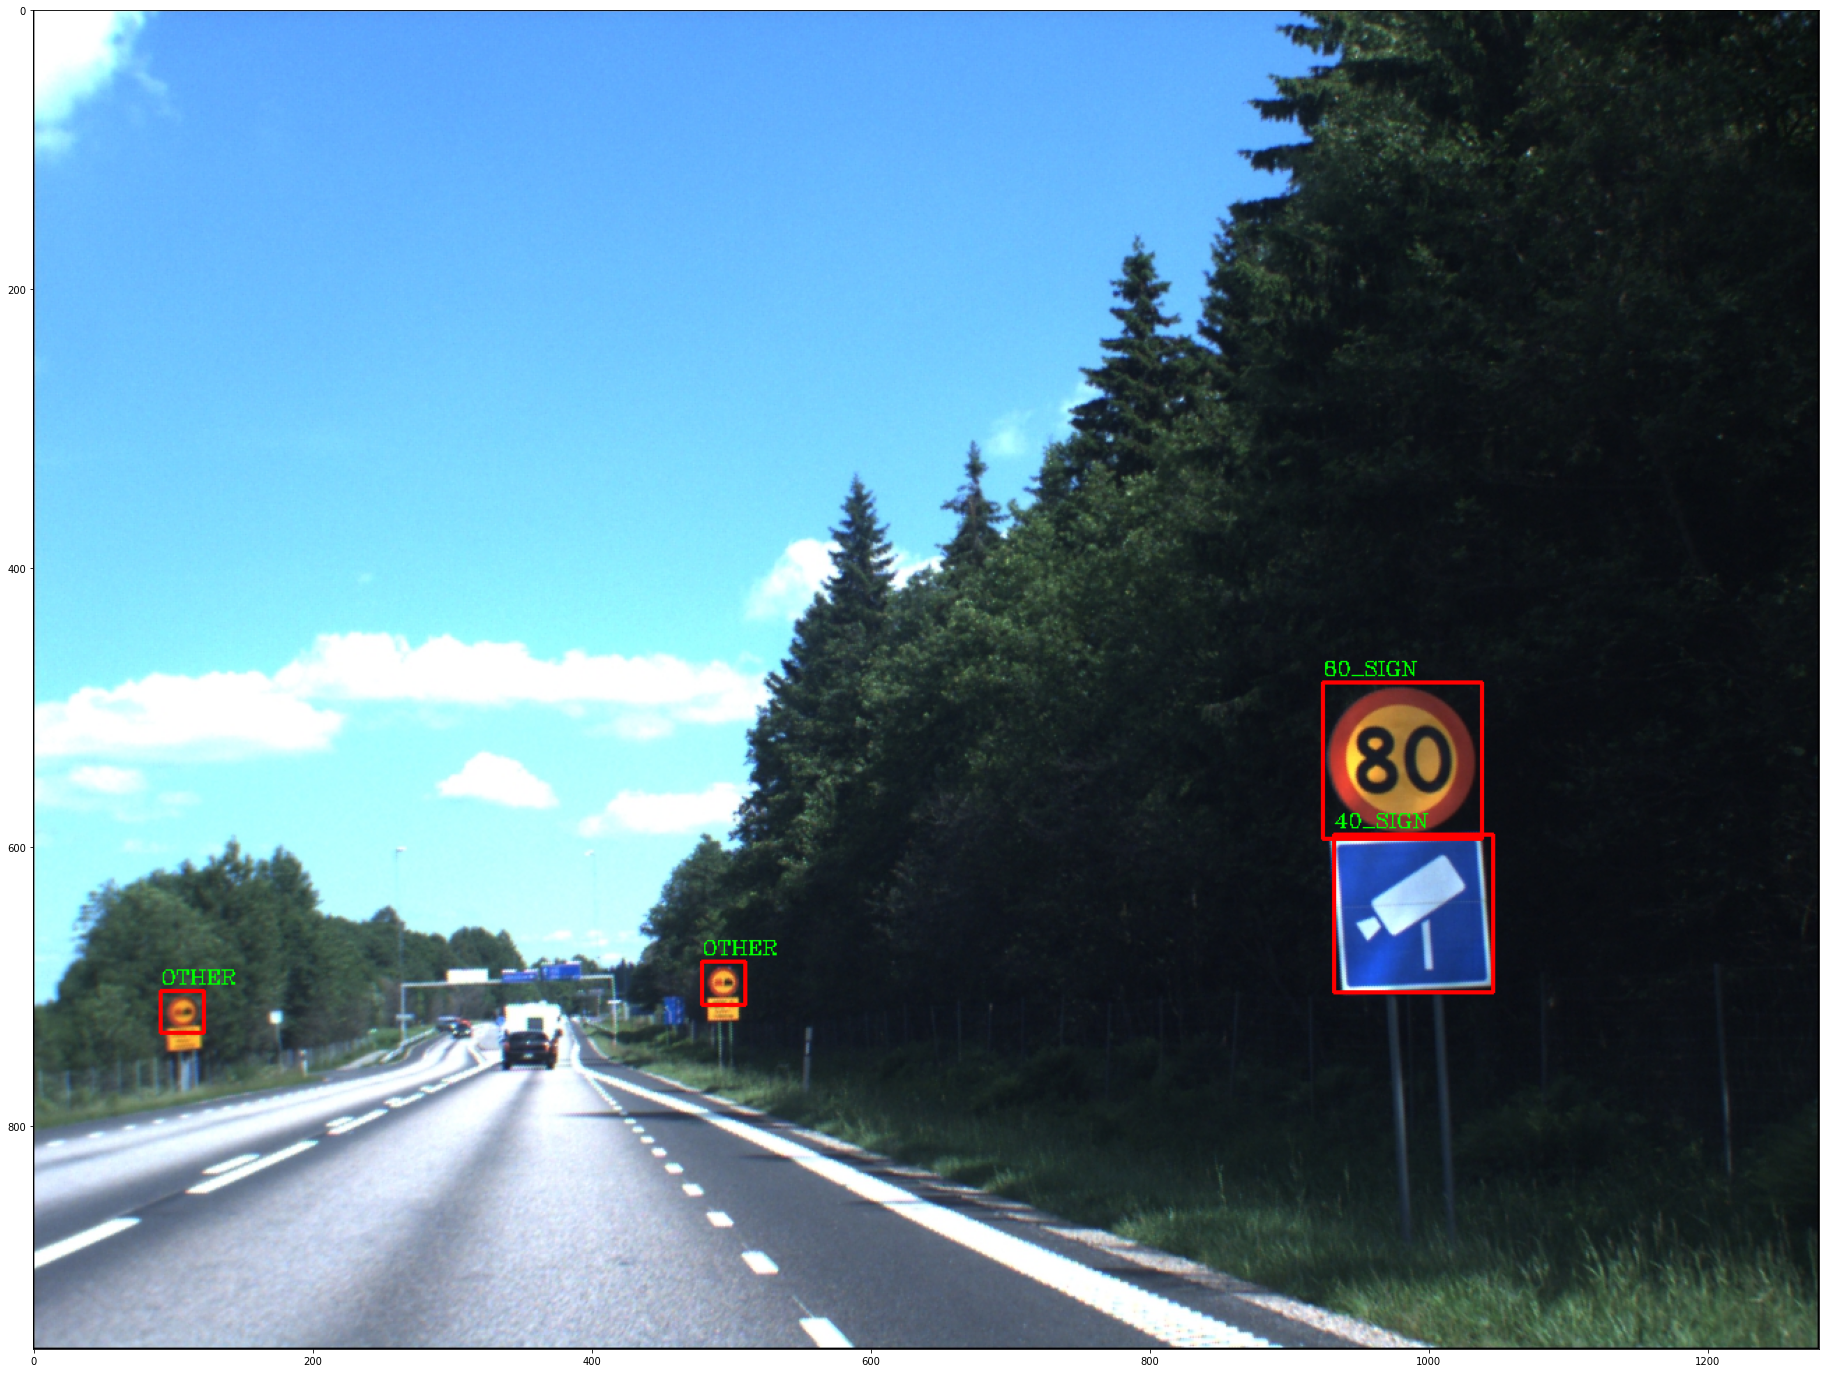

In [509]:
images = {}

for image_file in images_files:
    images[image_file] = (cv2.imread(input_path + "/" + image_file))
    
plt.figure(figsize=(32, 32))
image_to_test = (images[images_files[2]])
# plt.imshow(image_to_test)
imag = classify_ROI(image_to_test)
plt.imshow(imag)

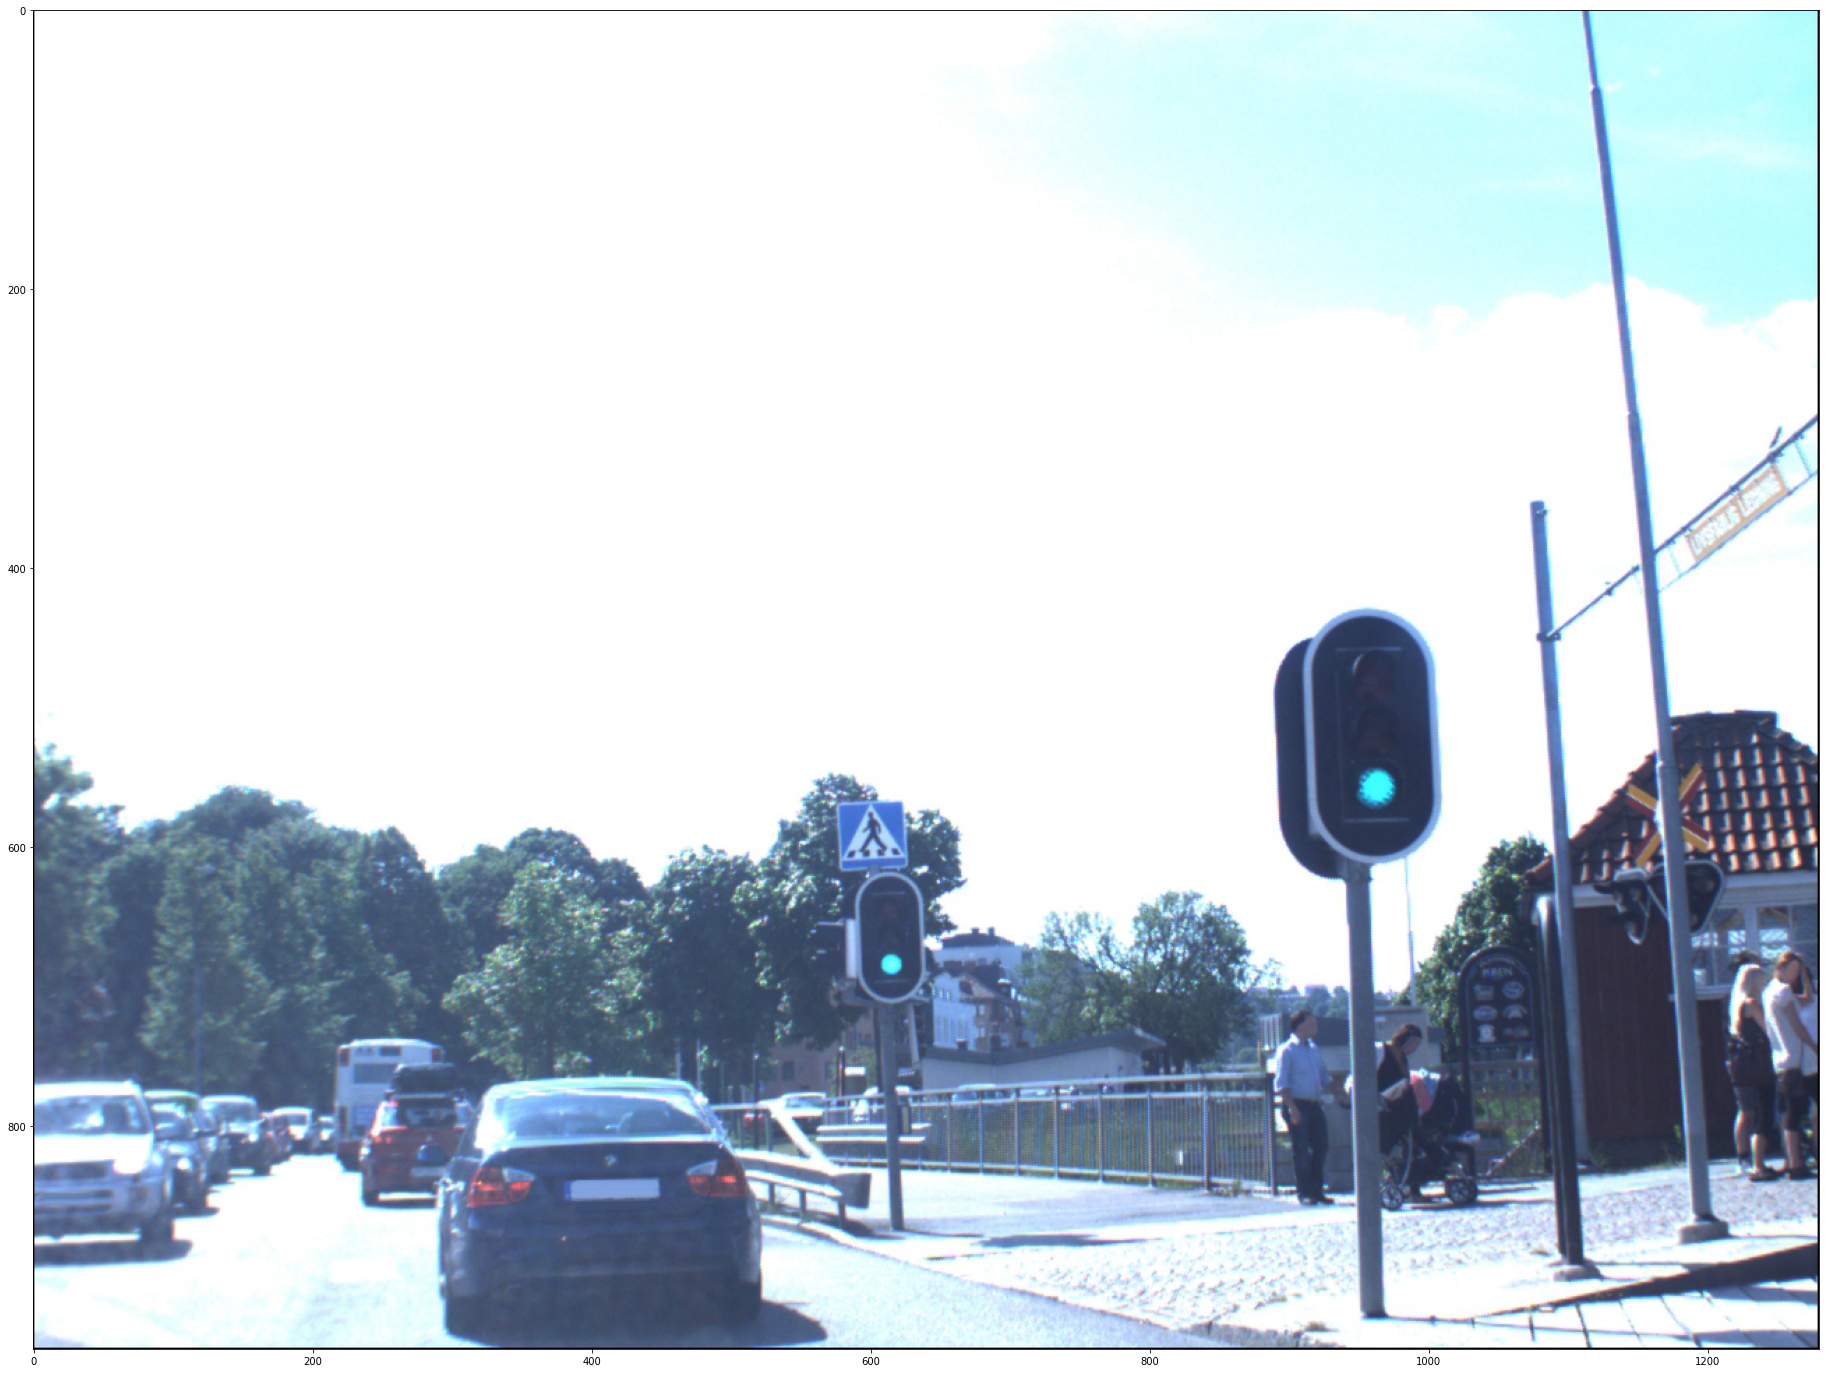

In [297]:
image_to_test = (images[images_files[13]])
plt.figure(figsize=(32,32))

RGB_img = cv2.cvtColor(image_to_test, cv2.COLOR_BGR2RGB)

plt.imshow(RGB_img)

(532, 657, 10, 31)
(519, 657, 5, 31)
(501, 656, 11, 31)
(529, 630, 13, 17)
(501, 630, 13, 16)
(407, 49, 5, 3)
(356, 44, 1, 1)
(411, 42, 6, 7)
(438, 40, 1, 1)
(502, 22, 2, 1)
(534, 18, 3, 2)
(270, 14, 1, 1)
(245, 6, 323, 45)


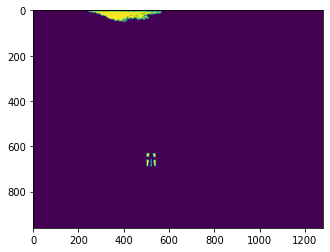

In [76]:
blue_masked = blue_mask(image_to_test)
plt.imshow(blue_masked)

cnts = cv2.findContours(blue_masked.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(cnts)

for contour in contours:
    approx = cv2.approxPolyDP(contour, 0.01* cv2.arcLength(contour, True), True)
    x = approx.ravel()[0]
    y = approx.ravel()[1] - 5

    coords = cv2.boundingRect(approx)
    print(coords)

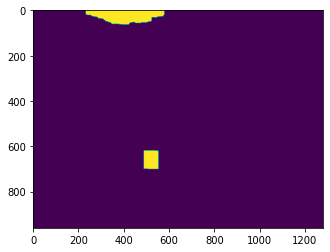

In [124]:
im_in = blue_masked

size = (25, 25)
shape = cv2.MORPH_RECT
kernel = cv2.getStructuringElement(shape, size)
min_image = cv2.dilate(im_in, kernel)

plt.imshow(min_image)
